# YOLOv8 benchmark, export and serve in AML

## Benchmarking

In [ ]:
# Install YOLOv8
%pip install ultralytics
%pip install onnx

In [2]:
# Import YOLOv8 benchmarks
from ultralytics.yolo.utils.benchmarks import benchmark

In [ ]:
# Benchmark model
benchmark(model='yolov8l.pt', imgsz=640, half=False, device=0)   # device 0 for GPU or "cpu" for CPU)
benchmark(model='yolov8n.pt', imgsz=640, half=False, device=0)   # device 0 for GPU or "cpu" for CPU)

#### Results
| VM Type | Time nano (ms)| Time large (ms) | VM price per hour (USD) | Price per 1M images nano (USD) | Price per 1M images large (USD) |
| ------- | ----------- | ------------ | ----------- | ----------- | ----------- |
| STANDARD_D2AS_V4 | 123 | 1782 | 0.115 | 3.39 | 56.93 |
| STANDARD_NC24ADS_A100_V4 | 5 | 8 | 4.78 | 6.64 | 10.62 |
| STANDARD_D96A_V4 | 36 | 139 | 4.9 |  49 | 189.18 |

In [20]:
def price_per_1M_images(speed, price):
    return round(price / (1000*60*60/speed)*1000000, 2)

print("----- nano ------")
print(f"STANDARD_D2AS_V4 nano: {price_per_1M_images(123, 0.115)} USD")
print(f"STANDARD_D96A_V4 nano: {price_per_1M_images(36, 4.9)} USD")
print(f"STANDARD_NC24ADS_A100_V4 nano: {price_per_1M_images(5, 4.78)} USD")
print()
print("----- large ------")
print(f"STANDARD_D2AS_V4 large: {price_per_1M_images(1782, 0.115)} USD")
print(f"STANDARD_D96A_V4 large: {price_per_1M_images(139, 4.9)} USD")
print(f"STANDARD_NC24ADS_A100_V4 large: {price_per_1M_images(8, 4.78)} USD")

----- nano ------
STANDARD_D2AS_V4 nano: 3.93 USD
STANDARD_D96A_V4 nano: 49.0 USD
STANDARD_NC24ADS_A100_V4 nano: 6.64 USD

----- large ------
STANDARD_D2AS_V4 large: 56.93 USD
STANDARD_D96A_V4 large: 189.19 USD
STANDARD_NC24ADS_A100_V4 large: 10.62 USD


## Export to ONNX

In [ ]:
from ultralytics import YOLO
import os

# Load models
model_yolov8n = YOLO('models/yolov8n/1/yolov8n.pt')  # load an official model
model_yolov8l = YOLO('models/yolov8l/1/yolov8l.pt')  # load an official model


In [ ]:

# Export models
model_yolov8n.export(format='onnx')
model_yolov8l.export(format='onnx')

# Rename models
os.replace('models/yolov8n/1/yolov8n.onnx', 'models/yolov8n/1/model.onnx')
os.replace('models/yolov8l/1/yolov8l.onnx', 'models/yolov8l/1/model.onnx')

# Delete pytorch version of model
os.remove('models/yolov8n/1/yolov8n.pt')
os.remove('models/yolov8l/1/yolov8l.pt')

## Serve in Azure Machine Learning

In [ ]:
%pip install numpy --user --upgrade
%pip install tritonclient[http] --user --upgrade
%pip install pillow --user --upgrade
%pip install gevent --user --upgrade
%pip install azure-ai-ml --user --upgrade

In [1]:
# Variables
subscription_id = "d3b7888f-c26e-4961-a976-ff9d5b31dfd3"
resource_group = "toml"
workspace_name = "tomlsw"
endpoint_name = "tomaskubica1423"

In [2]:
# Login
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id,
    resource_group,
    workspace_name,
)

In [6]:
# Create endpoint and deployment
from azure.ai.ml.entities import ManagedOnlineEndpoint

# Create endpoint
endpoint = ManagedOnlineEndpoint(name=endpoint_name, auth_mode="key")
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

In [ ]:
# Create deployment
from azure.ai.ml.entities import ManagedOnlineDeployment, Model

deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,
    model=Model(path="./models", type="triton_model"),
    instance_type="Standard_D2as_v4",
    instance_count=1,
)

ml_client.online_deployments.begin_create_or_update(deployment).result()

# Update traffic
endpoint.traffic = {"blue": 100}
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

In [ ]:
# Debug - run triton server locally
# !docker pull nvcr.io/nvidia/tritonserver:23.05-py3
# !docker run -it --rm -p8000:8000 -p8001:8001 -p8002:8002 -v ./models:/models nvcr.io/nvidia/tritonserver:23.05-py3 tritonserver --model-repository=/models

# Test Triton server

In [ ]:
# Install Triton client
%pip install tritonclient[http] --user --upgrade

In [3]:
# Imports
import tritonclient.http as tritonhttpclient
import gevent.ssl
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Get scoring URI and key
endpoint = ml_client.online_endpoints.get(endpoint_name)
scoring_uri = endpoint.scoring_uri
keys = ml_client.online_endpoints.get_keys(endpoint_name)
auth_key = keys.primary_key

# We remove the scheme from the url
url = scoring_uri[8:]

# Initialize client handler
triton_client = tritonhttpclient.InferenceServerClient(
    url=url,
    ssl=True,
    ssl_context_factory=gevent.ssl._create_default_https_context,
)

# Create headers
headers = {}
headers["Authorization"] = f"Bearer {auth_key}"

In [5]:
# Check Triton server is ready
health_ctx = triton_client.is_server_ready(headers=headers)
print("Is server ready - {}".format(health_ctx))

Is server ready - True


In [6]:
# List models on Triton server
triton_client.get_model_repository_index(headers=headers)

[{'name': 'yolov8l', 'version': '1', 'state': 'READY'},
 {'name': 'yolov8n', 'version': '1', 'state': 'READY'}]

In [11]:
# Check ready model status
model_name = "yolov8l"
version = "1"
triton_client.is_model_ready(model_name, version, headers)

True

In [14]:
# Load image file
img = cv2.imread('test.jpg')

# Store original image size
image_width, image_height = img.shape[:2]

# Preprocess image
img = cv2.resize(img, (640, 640))
img = img.astype(np.float32) / 255.0
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img, axis=0)

# Create inference request
input = tritonhttpclient.InferInput('images', img.shape, 'FP32')
input.set_data_from_numpy(img)

In [8]:
# Send inference request
outputs = [tritonhttpclient.InferRequestedOutput('output0')]
response = triton_client.infer('yolov8l', inputs=[input], outputs=outputs, headers=headers)

# Response time about 4,7s

In [9]:
# Get rid of first dimension (we have just one image)
output_data = response.as_numpy('output0')[0]

# Transpose to get 8400x84
output_data = output_data.transpose()

# Now each row is one bounding box
# First 4 numbers are bounding box coordinates, next 80 are probabilities for different classes
print(f"Row 0: x_center: {output_data[0][0]} y_center: {output_data[0][1]} width: {output_data[0][2]} height: {output_data[0][3]}")
print(f"Classes probabilities: {output_data[0][4:]}")

Row 0: x_center: 10.970717430114746 y_center: 4.042498588562012 width: 23.763792037963867 height: 10.321962356567383
Classes probabilities: [1.9371510e-06 2.0861626e-07 4.4703484e-07 1.4901161e-07 5.0663948e-07
 1.1920929e-07 5.9604645e-08 2.3841858e-07 4.7683716e-07 8.0466270e-07
 1.1920929e-07 4.1723251e-07 1.4901161e-07 3.5762787e-07 2.4437904e-06
 2.0861626e-07 2.3841858e-07 4.1723251e-07 5.3644180e-07 4.7683716e-07
 2.9802322e-07 2.6822090e-07 4.7683716e-07 5.0663948e-07 1.1920929e-07
 1.1026859e-06 2.0861626e-07 2.9802322e-07 5.9604645e-08 2.6822090e-07
 3.2782555e-07 2.3841858e-07 5.0663948e-07 1.6391277e-06 1.4901161e-07
 1.4901161e-07 2.0861626e-07 4.7683716e-07 3.8743019e-07 3.5762787e-07
 3.5762787e-07 2.6822090e-07 1.7881393e-07 2.3841858e-07 1.7881393e-07
 2.3841858e-07 4.7683716e-07 4.1723251e-07 1.7881393e-07 6.8545341e-07
 2.0861626e-07 2.9802322e-07 1.4901161e-07 1.7881393e-07 2.3841858e-07
 1.4901161e-07 8.0466270e-07 1.7881393e-07 6.8545341e-07 2.3841858e-07
 3.57627

In [10]:
# Find bounding box with highest probability and print class id
yolo_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

prob = output_data[0][4:].max()
class_id = output_data[0][4:].argmax()
print(f"Label: {yolo_classes[class_id]} with probability: {prob}")

Label: bird with probability: 2.4437904357910156e-06


In [17]:
# Cycle through all bounding boxes and print those with probability higher than 0.5
boxes = []

for i, row in enumerate(output_data):
    prob = row[4:].max()
    class_id = row[4:].argmax()
    if prob > 0.5:
        x_center, y_center, width, height = row[:4]
        x = int((x_center - (width / 2)) / 640 * image_width)
        y = int((y_center - (height / 2)) / 640 * image_height)
        w = int(width / 640 * image_width)
        h = int(height / 640 * image_height)
        x2 = x + w
        y2 = y + h
        print(f"Row: {i} Label: {yolo_classes[class_id]} Probability: {prob} Coordinates: {x, y, x2, y2}")
        boxes.append({"label":yolo_classes[class_id], "coordinates": (x, y, x2, y2)})

# Note some boxes are "duplicates" as they are having eg. just 1 pixel difference
# We should "dedpulicate" them, but in our case we will just draw all of them

Row: 1464 Label: bird Probability: 0.6160368323326111 Coordinates: (172, 136, 222, 169)
Row: 1465 Label: bird Probability: 0.6021742224693298 Coordinates: (173, 136, 222, 168)
Row: 1466 Label: bird Probability: 0.5969414710998535 Coordinates: (174, 136, 223, 168)
Row: 1543 Label: bird Probability: 0.6512818336486816 Coordinates: (173, 136, 222, 168)
Row: 1544 Label: bird Probability: 0.605888307094574 Coordinates: (173, 136, 222, 169)
Row: 1545 Label: bird Probability: 0.6010562777519226 Coordinates: (173, 136, 222, 169)
Row: 1546 Label: bird Probability: 0.6660826206207275 Coordinates: (174, 136, 222, 169)
Row: 1624 Label: bird Probability: 0.5813634395599365 Coordinates: (173, 136, 222, 169)
Row: 1625 Label: bird Probability: 0.5755418539047241 Coordinates: (174, 136, 223, 169)
Row: 1626 Label: bird Probability: 0.5425906181335449 Coordinates: (174, 136, 222, 169)
Row: 4224 Label: person Probability: 0.6522736549377441 Coordinates: (506, 410, 528, 458)
Row: 4225 Label: person Probabi

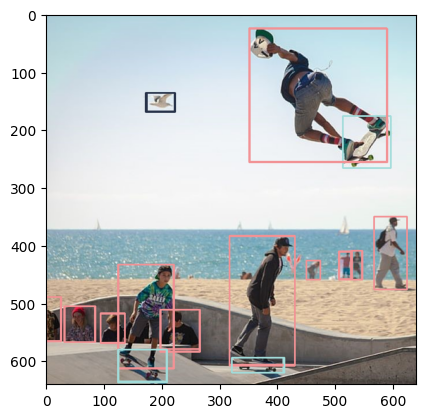

In [13]:
# Generate random color for each class
colors = {}
for class_id in range(80):
    colors[class_id] = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

# Show boxes
imgresult = cv2.imread("test.jpg")

for box in boxes:
    cv2.rectangle(
        imgresult,
        (box["coordinates"][0], box["coordinates"][1]),
        (box["coordinates"][2], box["coordinates"][3]),
        colors[yolo_classes.index(box["label"])],
        2,
    )


plt.imshow(cv2.cvtColor(imgresult, cv2.COLOR_BGR2RGB))